## Using Financial Fundamentals Data to forecast EPS

### Uni-variable linear models via scikit-learn and statsmodels
In this example you will be be using various financial fundamentals data to predict future Earning Per Share (EPS).
In this exercise you will be using linear regression model. The dataset is quarterly time series of various financial fundamentals.

In [2]:
%pylab inline
import os.path
import pandas as pd
from pymlfin.util.util import get_eps_data

print(os.getcwd())
df = get_eps_data('MSFT')
df.reset_index(level=0, inplace=True) # remove GVKEY from the DataFrame's index
df.loc[:,('EPS_t1', 'EPS_t4', 'EPS_t5','INV_t1', 'AR_t1', 'SA_t1', 'GM_t1', 'CAPX_t1', 'ETR_t1', 'EPS')].head()

Populating the interactive namespace from numpy and matplotlib
/Users/volodymyrchernat/PycharmProjects/mlfin


,EPS_t1,EPS_t4,EPS_t5,INV_t1,AR_t1,SA_t1,GM_t1,CAPX_t1,ETR_t1,EPS
datadate,,,,,,,,,,
1987-06-30,0.69,0.42,0.42,0.516249,2.074071,1.379797,2.617770,0.624669,0.444283,0.62
1987-09-30,0.62,0.57,0.42,0.597956,1.991295,1.664993,2.621289,2.095536,0.337975,0.38
1987-12-31,0.38,0.71,0.57,0.414236,1.005384,0.931504,1.515684,0.190183,0.345454,0.63
1988-03-31,0.63,0.69,0.71,0.514385,1.488524,1.160860,2.147013,0.413706,0.342557,0.67
1988-06-30,0.67,0.62,0.69,0.767657,1.540407,1.237758,2.228054,0.698531,0.317291,0.54


####  Model M1.3 by Foster (1977)
First we consider model M1.3 by Foster (1977)
$$ EPS_t = EPS_{t-4} + \phi_1 [EPS_{t-1} - EPS_{t-5}] + \delta_t$$
Where $\delta_t \sim N(0,1)$ is a residual term. 

Notice that the data we are given does not contain $EPS_{t-1}-EPS_{t-5}$. Hence, we need to compute the missing columns.

In [6]:
df['EPS_t1_minus_EPS_t5'] = df['EPS_t1'] - df['EPS_t5']
df = df.loc[:,('EPS_t1', 'EPS_t4', 'EPS_t5', 'EPS_t1_minus_EPS_t5', 
          'INV_t1', 'AR_t1', 'SA_t1', 'GM_t1', 'CAPX_t1', 'ETR_t1', 'EPS')]
df = df.dropna()    # remove rows with NAs so that result could be used with OLS
df.head()

,EPS_t1,EPS_t4,EPS_t5,EPS_t1_minus_EPS_t5,INV_t1,AR_t1,SA_t1,GM_t1,CAPX_t1,ETR_t1,EPS
datadate,,,,,,,,,,,
1987-06-30,0.69,0.42,0.42,0.27,0.516249,2.074071,1.379797,2.617770,0.624669,0.444283,0.62
1987-09-30,0.62,0.57,0.42,0.20,0.597956,1.991295,1.664993,2.621289,2.095536,0.337975,0.38
1987-12-31,0.38,0.71,0.57,-0.19,0.414236,1.005384,0.931504,1.515684,0.190183,0.345454,0.63
1988-03-31,0.63,0.69,0.71,-0.08,0.514385,1.488524,1.160860,2.147013,0.413706,0.342557,0.67
1988-06-30,0.67,0.62,0.69,-0.02,0.767657,1.540407,1.237758,2.228054,0.698531,0.317291,0.54


In [13]:
import statsmodels.formula.api as sm
import statsmodels.api as sm_api

ols_foster_result = sm.ols(formula="EPS ~ EPS_t4 + EPS_t1_minus_EPS_t5", data=df).fit()
print(type(ols_foster_result))
print(ols_foster_result.summary())

<class 'statsmodels.regression.linear_model.RegressionResultsWrapper'>
                            OLS Regression Results                            
Dep. Variable:                    EPS   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     35.74
Date:                Sat, 19 Aug 2017   Prob (F-statistic):           8.08e-13
Time:                        18:02:21   Log-Likelihood:                 24.155
No. Observations:                 119   AIC:                            -42.31
Df Residuals:                     116   BIC:                            -33.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

Lets look at what we've got after fitting Foster (1977) model to our time series. Impressively, all the model coeffcients are significantly different from zero which is indicated by the t-statistics from the statsmodels.regression.linear_model.RegressionResultsWrapper. All values in $P>|t|$ column are less than 0.05. We use an entire data set on purpose, but in practice we would partition available data into training and test. More on this will follow.

Here we digress a little bit into time series analysis. The M1.3 model specification requires $\delta_t \sim N(0,1)$. We will test residuals for normality.

In [9]:
# analyzing the residuals
import scipy.stats
print("Normal residuals?")
chi_squared_stats = scipy.stats.normaltest(ols_foster_result.resid)
print(chi_squared_stats)
if chi_squared_stats[1] < 0.055:
    print('The residuals are not from normal distribution')
else:
    print('The residuals are from normal distribution')

Normal residuals?
NormaltestResult(statistic=34.29512605463011, pvalue=3.5719716156543415e-08)
The residuals are not from normal distribution


scipy.stats.normaltest returns a 2-tuple of the chi-squared statistic, and the associated p-value. Given the null hypothesis that the input data came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen. If the p-value is very small, it means it is unlikely that the data came from a normal distribution. 

In [12]:
print("Durbin-Watson test for residuals")
print(sm_api.stats.durbin_watson(ols_foster_result.resid))

Durbin-Watson test for residuals
1.79002596342


Does our model obey the theory? We will use the Durbin-Watson test for auto-correlation. The Durbin-Watson statistic ranges in value from 0 to 4.
* A value near 2 indicates non-auto-correlation
* A value toward 0 indicates positive auto-correlation
* A value toward 4 indicates negative auto-correlation

The value of Durbin-Watson statistic is close to 2 if the errors are uncorrelated. In our case, the residuals are not auto-correlated, which is a desired property as per model specification we want residuals that are normally distributed (0,1) and independent. We could also use Durbin-Watson statistic to analyze the degree of auto-correlation in the original EPS time-series. We will do so in the code that follows. 

In [11]:
print("Durbin-Watson test for EPS time series")
print(sm_api.stats.durbin_watson(df['EPS']))

Durbin-Watson test for EPS time series
0.128290411271


It helps to examine time series through lens of Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF). We do so in the plots that follow.

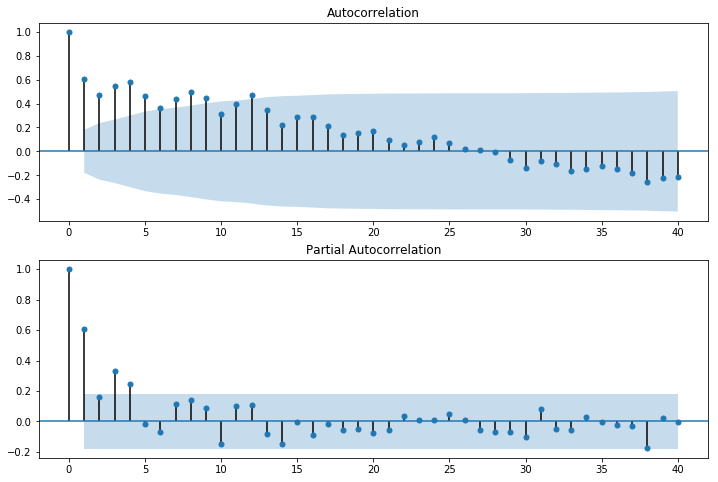

In [14]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm_api.graphics.tsa.plot_acf(df['EPS'].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm_api.graphics.tsa.plot_pacf(df['EPS'], lags=40, ax=ax2)

#### Model M1.1 Brown & Rozeff (1979)
 
Now that we have examined ACF and PACF for the time series we turn to another model, which in addition to lagged terms has a moving average term in its model specification. By introducing moving average (MA-term) the M1.1 model attempts to account for seasonality in the EPS time series. In particular, we turn to model M1.1 by Brown and Rozeff (1979).  

$$ EPS_t = EPS_{t-4} + \phi_1[EPS_{t-1} - EPS_{t-5}] + \Theta_1 * \alpha_{t-4} + \delta_t$$
Where:
* $\Theta_1$ - seasonal  moving average parameter
* $\theta$ - moving average parameter
* $\delta$ - constant term in ARIMA models

__M1.1__ model has (1,0,0) x (0, 1, 1)_4 specification, i.e. (p, d, q) x (P, D, Q)_s where s is the periodicity of the time series.

__p__ - is the auto-regressive part of the model. Allows to incorporate the effect of past values into the model.
Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

__d__ - is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing, (i.e. the number of past time points to subtract from the current value). Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
__d__ - is the number of nonseasonal terms needed for stationarity.

__q__ - is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past. *q* is the number of lagged forecast errors in the prediction equation.

M1.1 Brown & Rozeff (1979)
                                 Statespace Model Results                                
Dep. Variable:                               EPS   No. Observations:                  119
Model:             SARIMAX(1, 0, 0)x(0, 1, 1, 4)   Log Likelihood                  29.635
Date:                           Sat, 19 Aug 2017   AIC                            -53.269
Time:                                   18:47:04   BIC                            -44.932
Sample:                               06-30-1987   HQIC                           -49.884
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4790      0.065      7.316      0.000       0.351       0.607
ma.S.L4       -0

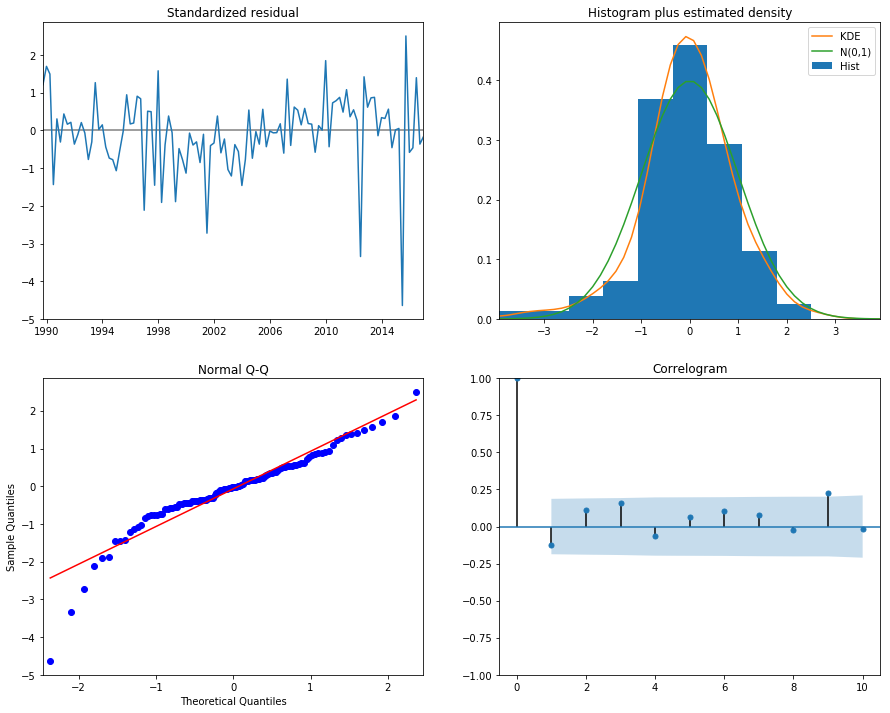

In [18]:
brown_rozeff_model = sm_api.tsa.statespace.SARIMAX(df['EPS'],
                                                       order=(1, 0, 0),
                                                       seasonal_order=(0, 1, 1, 4),
                                                       enforce_stationarity=False,
                                                       enforce_invertibility=False).fit()

print("M1.1 Brown & Rozeff (1979)")
print(brown_rozeff_model.summary())
print("Normal residuals?")
chi_squared_stats = scipy.stats.normaltest(brown_rozeff_model.resid)
print(chi_squared_stats)
if chi_squared_stats[1] < 0.055:
    print('Brown & Rozeff residuals are not from normal distribution')
else:
    print('Brown & Rozeff residuals are from normal distribution')
    
# visualize fit quality of SARIMAX model
print(type(brown_rozeff_model))
brown_rozeff_model.plot_diagnostics(figsize=(15, 12))
plt.show()